# Blue Food: Export, Import, Production
Export, import, and production of "food from the sea", by country and by year. Intention is to highlight proportions between domestic production and import/export of blue food.

Note that this is a parameterized widget; the specification passed to the API will not be renderable without the geostore identifier being inserted.  

_Author: Peter Kerins_  
_Created: 18 Aug 2021_  
_Environment: jupyterlab_  

## Style
- Vega chart
- Ocean Watch country page - parameterized chart
- Time series
- Vertical bar chart
- Area chart

## Data
Underlying dataset: [foo.061 Food from the Sea](https://resourcewatch.carto.com/u/wri-rw/dataset/foo_061_rw0_blue_food_supply_edit)
Widget data: [ow_widget_territory](https://resourcewatch.carto.com/u/wri-rw/dataset/ow_widget_territory) (master table for all territory-based widgets on Ocean Watch)  

## Preparation

In [1]:
import json
from vega import Vega
from IPython.display import display

In [2]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [3]:
widget_width = 400
widget_height = 300

# Data Exploration

Pivot version for data inspection
```sql
SELECT gid_0, date,
  SUM(CASE WHEN variable = 'Export Quantity' THEN value END) AS export,
  SUM(CASE WHEN variable = 'Import Quantity' THEN value END) AS import,
  SUM(CASE WHEN variable = 'Production' THEN value END) AS production
FROM ow_widget_territory
WHERE widget = 'net exports and imports' 
GROUP BY gid_0, date
ORDER BY gid_0 ASC, date ASC
```

Note that there are many instances where export exceeds production. This implies the inclusion of value-added processes, eg canning, which precludes certain comparisons or conclusions.
```sql
SELECT * FROM (
  SELECT gid_0, date,
    SUM(CASE WHEN variable = 'Export Quantity' THEN value END) AS export,
    SUM(CASE WHEN variable = 'Import Quantity' THEN value END) AS import,
    SUM(CASE WHEN variable = 'Production' THEN value END) AS production
  FROM ow_widget_territory
  WHERE widget = 'net exports and imports' 
  GROUP BY gid_0, date
  ORDER BY gid_0 ASC, date ASC) AS subq
WHERE export > production
```

# Widget

## Demo Query
`gid_0 = <territory>` used as stand-in for parameterized `geostore_prod={{geostore_id}}`
```sql
SELECT gid_0, date,
  SUM(CASE WHEN variable = 'Export Quantity' THEN value END) AS export,
  SUM(CASE WHEN variable = 'Import Quantity' THEN value END) AS import,
  SUM(CASE WHEN variable = 'Production' THEN value END) AS production
FROM ow_widget_territory
WHERE widget = 'net exports and imports' 
AND gid_0 = 'BRA'
GROUP BY gid_0, date
ORDER BY gid_0 ASC, date ASC
```

## Parameterized Query
```sql
SELECT territory.gid_0, territory.date,
  SUM(CASE WHEN territory.variable = 'Export Quantity' THEN value END) AS export,
  SUM(CASE WHEN territory.variable = 'Import Quantity' THEN value END) AS import,
  SUM(CASE WHEN territory.variable = 'Production' THEN value END) AS production
FROM ow_widget_territory AS territory
LEFT OUTER JOIN gadm36_0 AS gadm ON territory.gid_0 = gadm.gid_0
WHERE territory.widget = 'net exports and imports' 
AND gadm.gid_0 ILIKE '{{geostore_id}}'
GROUP BY territory.gid_0, territory.date
ORDER BY territory.gid_0 ASC, territory.date ASC
```

## Specification
Vega code presumes RW-style `config` element present

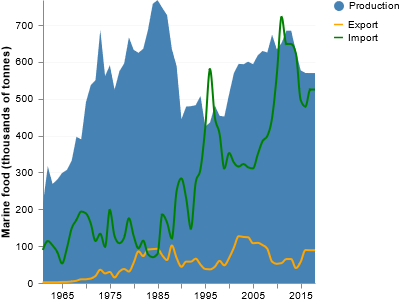

In [4]:
spec=json.loads("""
{
  "schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "Export, import, and production of food from the sea over time",
  "width": 400,
  "height": 250,
  "padding": 0,
  "autosize": {"type": "fit", "contains": "padding"},
  "signals": [],
  "data": [
    {
      "name": "reshaped",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT gid_0, date, SUM(CASE WHEN variable = 'Export Quantity' THEN value END) AS export, SUM(CASE WHEN variable = 'Import Quantity' THEN value END) AS import, SUM(CASE WHEN variable = 'Production' THEN value END) AS production FROM ow_widget_territory WHERE widget = 'net exports and imports' AND gid_0 = 'BRA' GROUP BY gid_0, date ORDER BY gid_0 ASC, date ASC",
      "format": {
        "type": "json",
        "property": "rows",
        "parse": {"date": "utc:'%Y'"}
      },
      "transform": []
    }
  ],
  "scales": [
    {
      "name": "datescale",
      "type": "time",
      "domain": {"data": "reshaped", "field": "date"},
      "range": "width"
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": {
        "data": "reshaped", 
        "fields": ["import", "export", "production"]
      },
      "range": "height",
      "padding": 0.1
    },
    {
      "name": "areascale",
      "type": "ordinal",
      "domain": ["Production"],
      "range": ["steelblue"]
    },
    {
      "name": "linescale",
      "type": "ordinal",
      "domain": ["Export", "Import"],
      "range": ["orange", "green"]
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "datescale",
      "domain": true,
      "labelFlush": true,
      "labelOverlap": true,
      "labelBaseline": "middle",
      "ticks": true,
      "grid": false,
      "labelFontSize": 10,
      "labelFont": "Arial",
      "labelPadding": 7
    },
    {
      "orient": "left",
      "scale": "yscale",
      "domain": true,
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 5,
      "grid": true,
      "gridOpacity": 0.2,
      "labelFontSize": 10,
      "labelFont": "Arial",
      "title": "Marine food (thousands of tonnes)"
    }
  ],
  "marks": [
    {
      "type": "area",
      "from": {
        "data": "reshaped"
      },
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "date"},
          "y": {"scale": "yscale", "field": "production"},
          "y2": {"scale": "yscale", "value": 0},
          "fill": {"value": "steelblue"},
          "tooltip": {
            "signal": "{'Year':utcyear(datum.date), 'Production':format(datum.production*1000,',')+' tonnes', 'Export':format(datum.export*1000,',')+' tonnes', 'Import':format(datum.import*1000,',')+' tonnes'}"
          }
        },
        "update": {
          "fillOpacity": {"value": 1}
        },
        "hover": {
          "fillOpacity": {"value": 0.5}
        }
      }
    },
    {
      "type": "line",
      "from": {"data": "reshaped"},
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "date"},
          "y": {"scale": "yscale", "field": "export"},
          "stroke": {"value": "orange"},
          "strokeWidth": {"value": 2},
          "interpolate": {"value": "monotone"}
        },
        "update": {
          "strokeOpacity": {"value": 1}
        },
        "hover": {
          "strokeOpacity": {"value": 0.5}
        }
      }
    },
    {
      "type": "line",
      "from": {"data": "reshaped"},
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "date"},
          "y": {"scale": "yscale", "field": "import"},
          "stroke": {"value": "green"},
          "strokeWidth": {"value": 2},
          "interpolate": {"value": "monotone"}
        },
        "update": {
          "strokeOpacity": {"value": 1}
        },
        "hover": {
          "strokeOpacity": {"value": 0.5}
        }
      }
    }
  ],
  "legends": [
    {
      "type": "symbol",
      "orient": "right",
      "fill": "areascale"
    },
    {
      "type": "symbol",
      "orient": "right",
      "symbol": "stroke",
      "stroke": "linescale",
      "encode": {
        "symbols": {
          "update": {
            "size": {"value": 80},
            "shape": {"value": "stroke"}
          }
        }
      }
    }
  ]
}
""")
vega_view=dict(spec)
vega_view['width']=widget_width
vega_view['height']=widget_height
Vega(vega_view)

# RW API

Parameterized widgets created via [widget scripts](https://github.com/resource-watch/data-team-tools/tree/master/advanced_widget_writer).  

[foo.061.rw0 Food from the Sea](https://resourcewatch.org/data/explore/foo061rw0-Blue-Food-Supply) ([Admin](https://resourcewatch.org/admin/data/datasets/9e1b3cad-db6f-44b0-b6fb-048df7b6c680/edit))  
`9e1b3cad-db6f-44b0-b6fb-048df7b6c680`  
[Dataset](https://api.resourcewatch.org/v1/dataset/9e1b3cad-db6f-44b0-b6fb-048df7b6c680/), [Widgets](https://api.resourcewatch.org/v1/dataset/9e1b3cad-db6f-44b0-b6fb-048df7b6c680/widget)

In [5]:
dataset_id = '9e1b3cad-db6f-44b0-b6fb-048df7b6c680'
name = 'Production, Export, and Import of Marine Food'
description = 'Time series volumes (by weight) of production, export, and import of food originating in the sea, by country'

- [Country](https://api.resourcewatch.org/v1/widget/a9c33b55-494c-4984-8bfd-0f5b008dcf24?env=production) `a9c33b55-494c-4984-8bfd-0f5b008dcf24`  